In [ ]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings("ignore")

### **Dataset information**

| Field name  | Description                 |
| ----------- | --------------------------- |
| ID          | Clump thickness             |
| Clump       | Clump thickness             |
| UnifSize    | Uniformity of cell size     |
| UnifShape   | Uniformity of cell shape    |
| MargAdh     | Marginal adhesion           |
| SingEpiSize | Single epithelial cell size |
| BareNuc     | Bare nuclei                 |
| BlandChrom  | Bland chromatin             |
| NormNucl    | Normal nucleoli             |
| Mit         | Mitoses                     |
| Class       | Benign or malignant         |




In [ ]:
path= "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/cell_samples.csv"

df = pd.read_csv(path)
df.head()

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           699 non-null    int64 
 1   Clump        699 non-null    int64 
 2   UnifSize     699 non-null    int64 
 3   UnifShape    699 non-null    int64 
 4   MargAdh      699 non-null    int64 
 5   SingEpiSize  699 non-null    int64 
 6   BareNuc      699 non-null    object
 7   BlandChrom   699 non-null    int64 
 8   NormNucl     699 non-null    int64 
 9   Mit          699 non-null    int64 
 10  Class        699 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 60.2+ KB


In [ ]:
df.nunique()

,0
ID,645
Clump,10
UnifSize,10
UnifShape,10
MargAdh,10
SingEpiSize,10
BareNuc,11
BlandChrom,10
NormNucl,10
Mit,9


In [ ]:
df['BareNuc'].unique()

array(['1', '10', '2', '4', '3', '9', '7', '?', '5', '8', '6'],
      dtype=object)

In [ ]:
# most frequent value in df['BareNuc']
df['BareNuc'].value_counts().idxmax()

'1'

In [ ]:
# Replace missing value with the most frequent value
df['BareNuc']= df['BareNuc'].replace('?', 1).astype('float')

In [ ]:
df['BareNuc'].unique()

array([ 1., 10.,  2.,  4.,  3.,  9.,  7.,  5.,  8.,  6.])

In [ ]:
df.Class.value_counts()

,count
Class,
2,458
4,241


In [ ]:
lb= LabelEncoder()
df['Class']= lb.fit_transform(df['Class'])

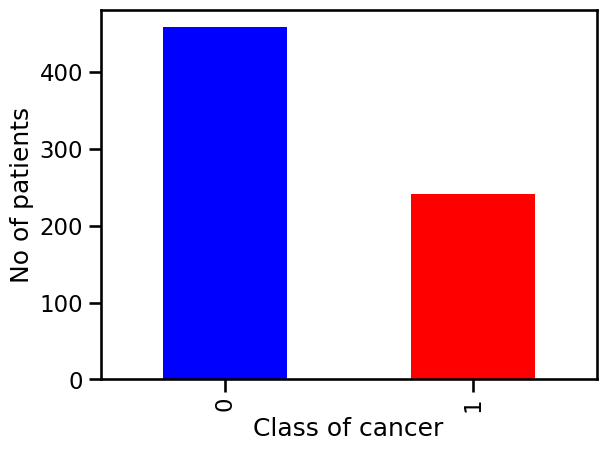

In [ ]:
ax= df['Class'].value_counts().plot.bar(color=['blue', 'red'])
ax.set(xlabel='Class of cancer', ylabel='No of patients')
plt.show()

In [ ]:
# Split the target and predictor variables
X, y= df.drop(columns=['Class', 'ID'], axis='columns'), df['Class']
X.shape, y.shape

((699, 9), (699,))

In [ ]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=234, stratify=y)

In [ ]:
X_train.shape, y_train.shape

((559, 9), (559,))

In [ ]:
y_train.value_counts()

,count
Class,
0,366
1,193


In [ ]:
y_test.value_counts()

,count
Class,
0,92
1,48


### **Applying SMOTE treat the imbalance data**

In [ ]:
smote= SMOTE(random_state= 234)
X_sm, y_sm= smote.fit_resample(X_train, y_train)

In [ ]:
y_sm.value_counts()

,count
Class,
0,366
1,366


## **Model Building**

# **Random Forest Classifier**

In [ ]:
model= RandomForestClassifier(bootstrap=True)
param_grid= {'n_estimators': [20, 40, 60, 80, 100, 120, 140, 160, 180, 200],
             'max_depth': [4, 6, 7, 9, 10, 11, 13, 15, 17, 19],
             'max_features': ['auto', 'sqrt', 'log2']}

In [ ]:
rf_search= GridSearchCV(estimator= model,
                        param_grid= param_grid,
                        scoring='accuracy',
                        cv=5)

rf_search.fit(X_sm, y_sm)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [4, 6, 7, 9, 10, 11, 13, 15, 17, 19],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [20, 40, 60, 80, 100, 120, 140, 160,
                                          180, 200]},
             scoring='accuracy')

In [ ]:
rf_search.best_score_

0.9822383748019756

In [ ]:
rf_search.best_params_

{'max_depth': 13, 'max_features': 'log2', 'n_estimators': 60}

In [ ]:
# Get test and train accuracy
def get_accuracy(X_train, X_test, y_train, y_test, model):
  return{'Test Accuracy': accuracy_score(y_test, model.predict(X_test)),
         'Train Accuracy': accuracy_score(y_train, model.predict(X_train))}

In [ ]:
get_accuracy(X_sm, X_test, y_sm, y_test, rf_search.best_estimator_)

{'Test Accuracy': 0.9428571428571428, 'Train Accuracy': 0.9986338797814208}

It seems to be overfitting

# **XGBoost Classifier**

In [ ]:
xgb= XGBClassifier(objective='binary:logistic', eval_metric='mlogloss')

param_grid= {'n_estimators': [50, 100, 200, 400],
             'learning_rate': [0.1, 0.01, 0.001]}

In [ ]:
xgb_search= GridSearchCV(estimator= xgb,
                         param_grid= param_grid,
                         scoring= 'accuracy',
                         cv=5)

xgb_search.fit(X_sm, y_sm)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'n_estimators': [50, 100, 200, 400]},
             scoring='accuracy')

In [ ]:
xgb_search.best_score_

0.9754076973255055

In [ ]:
xgb_search.best_params_

{'learning_rate': 0.01, 'n_estimators': 50}

In [ ]:
get_accuracy(X_sm, X_test, y_sm, y_test, xgb_search.best_estimator_)

{'Test Accuracy': 0.9285714285714286, 'Train Accuracy': 0.9754098360655737}

It seems to be overfitting with a difference of ~5

**Using early stopping to stop overfitting**

In [ ]:
# Use early stopping rounds of 10 to stop overfitting

eval_set= [(X_test, y_test)]
xgb_model = XGBClassifier(objective='binary:logistic',
                            n_estimators= 100,
                            eval_metric='logloss',
                            early_stopping_rounds=10)

xgb_model.fit(X_sm, y_sm, eval_set= eval_set, verbose=False)
y_pred = xgb_model.predict(X_test)
print(get_accuracy(X_sm, X_test, y_sm, y_test, xgb_model))

{'Test Accuracy': 0.9428571428571428, 'Train Accuracy': 0.9877049180327869}


Overfitting with a difference of ~ 4

**Using min_child_weight to stop overfitting**

In [ ]:
xgb_model2 = XGBClassifier(objective='binary:logistic',
                            learning_rate= 0.1,
                            n_estimators=100,
                            eval_metric='logloss',
                            min_child_weight=4)

xgb_model2.fit(X_sm, y_sm)
y_pred = xgb_model2.predict(X_test)
print(get_accuracy(X_sm, X_test, y_sm, y_test, xgb_model2))

{'Test Accuracy': 0.9428571428571428, 'Train Accuracy': 0.98224043715847}


Using gamma, reg_lambda, alpha to stop the overfitting

In [ ]:
xgb_model3 = XGBClassifier(objective='binary:logistic',
                            n_estimators=100,
                            eval_metric='logloss',
                            gamma=1,
                            reg_lambda=2,
                            alpha=1)

xgb_model3.fit(X_sm, y_sm)
y_pred = xgb_model3.predict(X_test)
print(get_accuracy(X_sm, X_test, y_sm, y_test, xgb_model3))

{'Test Accuracy': 0.95, 'Train Accuracy': 0.9808743169398907}


In [ ]:
xgb_model4 = XGBClassifier(objective='binary:logistic',
                            n_estimators=400,
                            eval_metric='logloss',
                            learning_rate= 0.1,
                            max_depth=4,
                            gamma=2,
                            reg_lambda=3,
                            alpha=2)

xgb_model4.fit(X_sm, y_sm)
y_pred = xgb_model4.predict(X_test)
print(get_accuracy(X_sm, X_test, y_sm, y_test, xgb_model4))

{'Test Accuracy': 0.95, 'Train Accuracy': 0.9795081967213115}


In [ ]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96        95
           1       0.90      0.96      0.92        45

    accuracy                           0.95       140
   macro avg       0.94      0.95      0.94       140
weighted avg       0.95      0.95      0.95       140



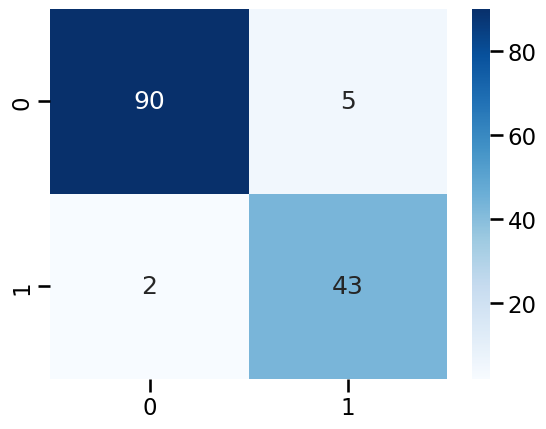

In [ ]:
sns.set_context("talk")
cm= confusion_matrix(y_pred, y_test)
ax= sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# **Logistic Regression**

In [ ]:
# Standard logistic regression
lr= LogisticRegression().fit(X_sm, y_sm)
lr_pred= lr.predict(X_test)

# Check for overfitting
print(get_accuracy(X_sm, X_test, y_sm, y_test, lr))

{'Test Accuracy': 0.9785714285714285, 'Train Accuracy': 0.9699453551912568}


**Standard logistic regression gave the best result and did not overfit**

In [ ]:
import pickle

pickle.dump(lr, (open('cancer_lr.p', 'wb')))
#cancer_lr= pickle.load(open('cancer_lr.p', 'rb'))

In [ ]:
print(classification_report(lr_pred, y_test))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98        93
           1       0.96      0.98      0.97        47

    accuracy                           0.98       140
   macro avg       0.97      0.98      0.98       140
weighted avg       0.98      0.98      0.98       140



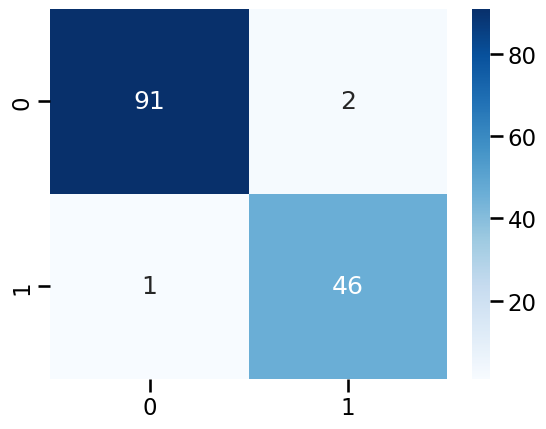

In [ ]:
cm= confusion_matrix(lr_pred, y_test)
ax= sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

In [ ]:
lr_lib= LogisticRegression(solver= 'liblinear').fit(X_sm, y_sm)
lr_pred= lr_lib.predict(X_test)
print(get_accuracy(X_sm, X_test, y_sm, y_test, lr_lib))

{'Test Accuracy': 0.9714285714285714, 'Train Accuracy': 0.9658469945355191}


In [ ]:
# L1 regularized logistic regression
lr_l1= LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver= 'liblinear')
lr_l1.fit(X_sm, y_sm)
print(get_accuracy(X_sm, X_test, y_sm, y_test, lr_l1))

{'Test Accuracy': 0.9714285714285714, 'Train Accuracy': 0.9644808743169399}


In [ ]:
# L2 regularized logistic regression
lr_l2= LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver= 'liblinear')
lr_l2.fit(X_sm, y_sm)
print(get_accuracy(X_sm, X_test, y_sm, y_test, lr_l2))

{'Test Accuracy': 0.9714285714285714, 'Train Accuracy': 0.9644808743169399}
